In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
#df = pd.read_csv('../elena/barros_2011_training.csv')
df = pd.read_csv('../data/training_final_latcorr.csv')

## Clean / Reverse Engineer Features
- Electricity generated (kWh)
- Drop redundant columns
- Drop non-lc columns

In [3]:
df['kWh'] = df['Area_km2'] / df['Area / Electricity']
df = df.drop(['Longitude', 'Latitude','CO2 (g/kWh)', 'CH4 (g/kWh)', 'Area / Electricity', 'Name', 'field_1',
              'temp_spring_avg', 'temp_summer_avg', 'temp_fall_avg', 'temp_winter_avg', 
              'NDVI_spring_avg', 'NDVI_summer_avg', 'NDVI_fall_avg', 'NDVI_winter_avg', 
              'npp_spring_avg' , 'npp_summer_avg' , 'npp_fall_avg' , 'npp_winter_avg'], axis=1)

In [4]:
df.columns

Index(['CO2 (mg C m¯² d¯¹)', 'CH4 (mg C m-2 d-1)', 'Area_km2', 'Age',
       'Volume_km3', 'Areakm2_div_Volkm3', 'org_c', 'temp_annual_avg',
       'temp_spring_avg_lc', 'temp_summer_avg_lc', 'temp_fall_avg_lc',
       'temp_winter_avg_lc', 'NDVI_annual_avg', 'NDVI_spring_avg_lc',
       'NDVI_summer_avg_lc', 'NDVI_fall_avg_lc', 'NDVI_winter_avg_lc',
       'npp_annual_avg', 'npp_spring_avg_lc', 'npp_summer_avg_lc',
       'npp_fall_avg_lc', 'npp_winter_avg_lc', 'erosion', 'precip', 'kWh'],
      dtype='object')

In [5]:
df.shape

(154, 25)

In [6]:
#create co2 df

In [7]:
ch4 = df.drop(['CO2 (mg C m¯² d¯¹)'], axis=1)
ch4 = ch4[ch4['CH4 (mg C m-2 d-1)'].notna()]

In [8]:
#missingness

In [9]:
from sklearn.impute import KNNImputer
model_impute = KNNImputer(n_neighbors=int(np.sqrt(ch4.shape[0])))
ch4_imputed = model_impute.fit_transform(ch4)

In [10]:
ch4_imputed = pd.DataFrame(columns=ch4.columns, data=ch4_imputed)

In [11]:
#check
for column in ch4_imputed:
    print(column, ':',  ch4_imputed[column].isna().sum())

CH4 (mg C m-2 d-1) : 0
Area_km2 : 0
Age : 0
Volume_km3 : 0
Areakm2_div_Volkm3 : 0
org_c : 0
temp_annual_avg : 0
temp_spring_avg_lc : 0
temp_summer_avg_lc : 0
temp_fall_avg_lc : 0
temp_winter_avg_lc : 0
NDVI_annual_avg : 0
NDVI_spring_avg_lc : 0
NDVI_summer_avg_lc : 0
NDVI_fall_avg_lc : 0
NDVI_winter_avg_lc : 0
npp_annual_avg : 0
npp_spring_avg_lc : 0
npp_summer_avg_lc : 0
npp_fall_avg_lc : 0
npp_winter_avg_lc : 0
erosion : 0
precip : 0
kWh : 0


### Random Forest

In [12]:
X = ch4_imputed.drop('CH4 (mg C m-2 d-1)', axis=1)
y = ch4_imputed['CH4 (mg C m-2 d-1)']

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
from sklearn import ensemble

randomForest = ensemble.RandomForestRegressor()
randomForest.set_params(random_state=42, n_estimators=200, max_features=10)
randomForest.fit(X_train, y_train)
randomForest.score(X_train, y_train)

0.8753130812356333

In [15]:
randomForest.score(X_test, y_test)

0.09157106645429891

In [16]:
print("The training error is: %.5f" % (1 - randomForest.score(X_train, y_train)))
print("The test     error is: %.5f" % (1 - randomForest.score(X_test, y_test)))

The training error is: 0.12469
The test     error is: 0.90843


#### grid search to find best parameters

In [17]:
from sklearn.model_selection import GridSearchCV

grid_values = {
    "n_estimators": range(200,500,50),
    "max_depth" : range(7,16),
    "max_features" : range(7,16)
}

grid_search_forest = GridSearchCV(randomForest, grid_values, scoring='r2', cv=2, n_jobs=-1)
%time grid_search_forest.fit(X_train, y_train)

Wall time: 10min 20s


GridSearchCV(cv=2,
             estimator=RandomForestRegressor(max_features=10, n_estimators=200,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(7, 16),
                         'max_features': range(7, 16),
                         'n_estimators': range(200, 500, 50)},
             scoring='r2')

In [18]:
grid_search_forest.best_params_

{'max_depth': 9, 'max_features': 8, 'n_estimators': 300}

In [19]:
grid_search_forest.best_score_

-0.8423742521005264

In [20]:
#using the best parameters, what is the test score?

randomForest.set_params(max_depth =9, max_features = 8, n_estimators = 300)
randomForest.fit(X_train, y_train)
randomForest.score(X_test, y_test)

0.09285920147030469

In [21]:
estimators = pd.DataFrame(grid_search_forest.cv_results_)[['param_n_estimators','mean_test_score']]
depth = pd.DataFrame(grid_search_forest.cv_results_)[['param_max_depth','mean_test_score']]

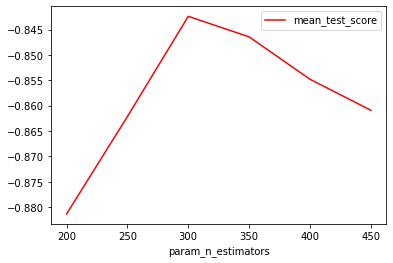

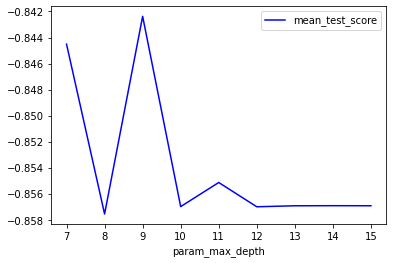

In [22]:
estimators.groupby('param_n_estimators').max().reset_index().plot(kind='line', x='param_n_estimators',y='mean_test_score', c='red')
depth.groupby('param_max_depth').max().reset_index().plot(kind='line', x='param_max_depth', y='mean_test_score', c='blue')
